In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../')
from src.dataset.fer_dataset import FERDataset
from tqdm import tqdm

from transformers import (
    AutoImageProcessor, 
    AutoModelForImageClassification, 
    AutoModel
)

from torch.utils.data import DataLoader
import torch

from torchvision.transforms.v2 import(
    CenterCrop,  
    Compose,  
    Normalize,  
    RandomRotation,  
    RandomResizedCrop,  
    RandomHorizontalFlip, 
    RandomAdjustSharpness,  
    Resize,  
    ToImage
)

# using pytorch lightning, train the a classification model
from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
#TODO: use pretrained model (dima for example)

In [3]:
train = FERDataset(root_dir='../data/fer-2013/train')
test = FERDataset(root_dir='../data/fer-2013/test')

In [4]:
backbone = AutoModel.from_pretrained('facebook/dinov2-small')
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small',use_fast=True)

In [5]:
size = dino_processor.size['shortest_edge']
train_trasnforms = Compose([
    ToImage(),
    Resize((size, size)),
    RandomRotation(degrees=90),
    RandomAdjustSharpness(sharpness_factor=2.0),
    RandomHorizontalFlip(0.5),
])

test_trasnforms = Compose([
    ToImage(),
    Resize((size, size)),
])

train.transform = train_trasnforms
test.transform = test_trasnforms

In [6]:
def dino_collate_fn(batch):
    img = [item['pixel_values'] for item in batch]
    labels = [item['label'] for item in batch]
    processed_img = dino_processor(img)
    
    img_tesnor = torch.stack(processed_img['pixel_values'])
    label_tensor = torch.tensor(labels, dtype=torch.long)
    return img_tesnor, label_tensor

In [7]:
train_loader = DataLoader(train, batch_size=16, shuffle=True, collate_fn=dino_collate_fn)
test_loader = DataLoader(test, batch_size=16, shuffle=False, collate_fn=dino_collate_fn)

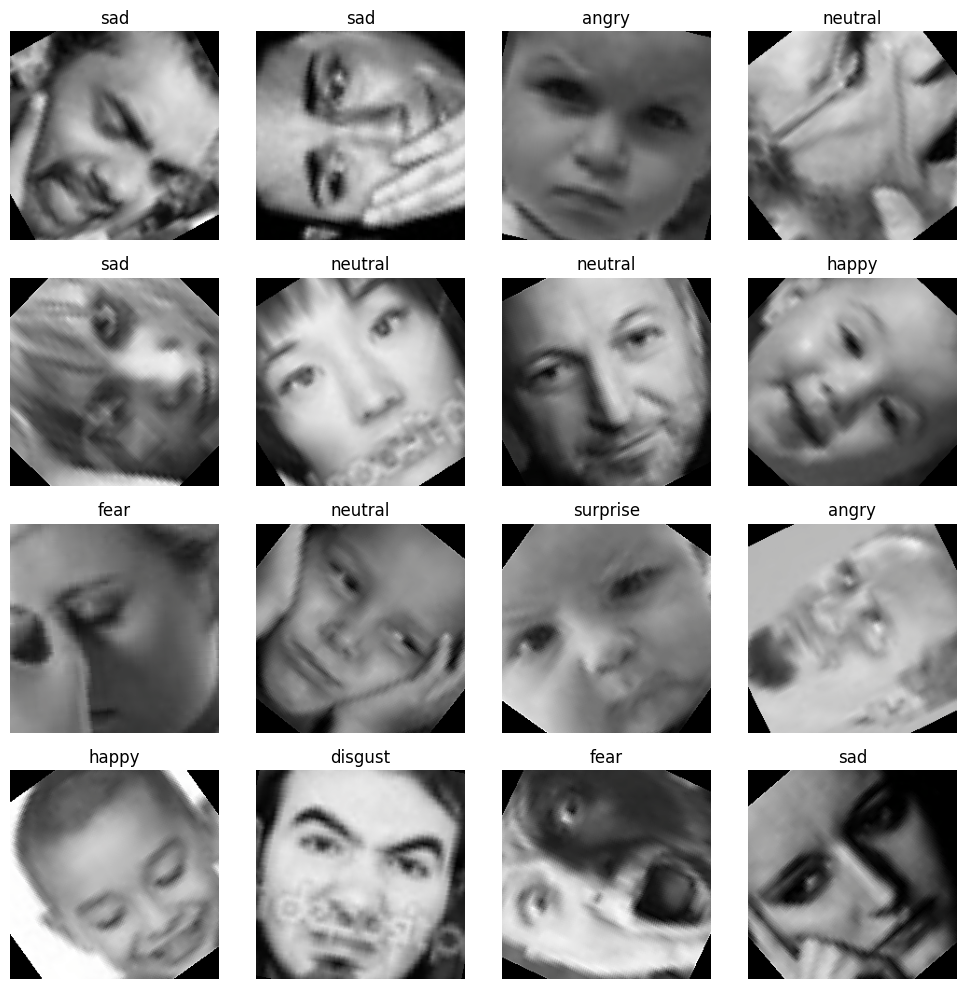

In [8]:
p_mean = dino_processor.image_mean
p_std = dino_processor.image_std

# given mean and std, denormalize the image
def denormalize(image, mean, std):
    # image is 3*224*224
    image = image.permute(1, 2, 0)  # Change to HWC format
    image = image * torch.tensor(std) + torch.tensor(mean)  # Denormalize
    image = image.clamp(0, 1)  # Ensure values are in [0, 1]
    return image
def plot_sample(sample, num_images=8, n_cols=4):
    images, labels = sample
    images = images[:num_images]
    labels = labels[:num_images]
    n_rows = (num_images + n_cols - 1) // n_cols  # Calculate number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2.5*n_rows))
    axes = axes.flatten() if num_images > 1 else [axes]
    for idx, (ax, img, label) in enumerate(zip(axes, images, labels)):
        rgb_image = denormalize(img, p_mean, p_std)
        ax.imshow(rgb_image)
        label = train.inverted_label_map[label.item()]
        ax.set_title(label)
        ax.axis('off')
    # Hide unused axes
    for ax in axes[len(images):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample = next(iter(train_loader))
plot_sample(sample, num_images=16)


In [9]:
class FERClassifier(LightningModule):
    def __init__(self, backbone, num_classes=7):
        super(FERClassifier, self).__init__()
        self.backbone = backbone 
        # freeze the backbone
        # for param in self.backbone.parameters():
            # param.requires_grad = False
        self.classifier = torch.nn.Linear(backbone.config.hidden_size, num_classes)
    
    def forward(self, x):
        # with torch.no_grad():
        x = self.backbone(x)
        features = x.last_hidden_state[:, 0, :]  # Use the CLS token
        logits = self.classifier(features)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', (logits.argmax(dim=1) == y).float().mean(), on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        # log accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-6, weight_decay=0.02)

In [10]:
trainer = Trainer(
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu'
)
backbone = AutoModel.from_pretrained('facebook/dinov2-small')
torch.set_float32_matmul_precision('high')
trainer.fit(model=FERClassifier(backbone), train_dataloaders=train_loader, val_dataloaders=test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | backbone   | Dinov2Model | 22.1 M | eval 
1 | classifier | Linear      | 2.7 K  | train
---------------------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.237    Total estimated model params size (MB)
1         Modules in train mode
224       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\tools\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\tools\miniconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [93]:
best_model = FERClassifier.load_from_checkpoint(trainer.checkpoint_callback.best_model_path, backbone=backbone)

In [99]:
y_true = []
y_pred = []

for batch in tqdm(test_loader):
    x, y = batch
    x = x.to(device)
    logits = best_model(x)
    preds = torch.argmax(logits, dim=1)
    
    y_true.extend(y.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

100%|██████████| 225/225 [00:33<00:00,  6.81it/s]


              precision    recall  f1-score   support

       angry       0.36      0.37      0.37       958
     disgust       0.14      0.01      0.02       111
        fear       0.33      0.21      0.26      1024
       happy       0.76      0.81      0.79      1774
     neutral       0.47      0.49      0.48      1233
         sad       0.39      0.50      0.44      1247
    surprise       0.62      0.56      0.59       831

    accuracy                           0.52      7178
   macro avg       0.44      0.42      0.42      7178
weighted avg       0.50      0.52      0.51      7178



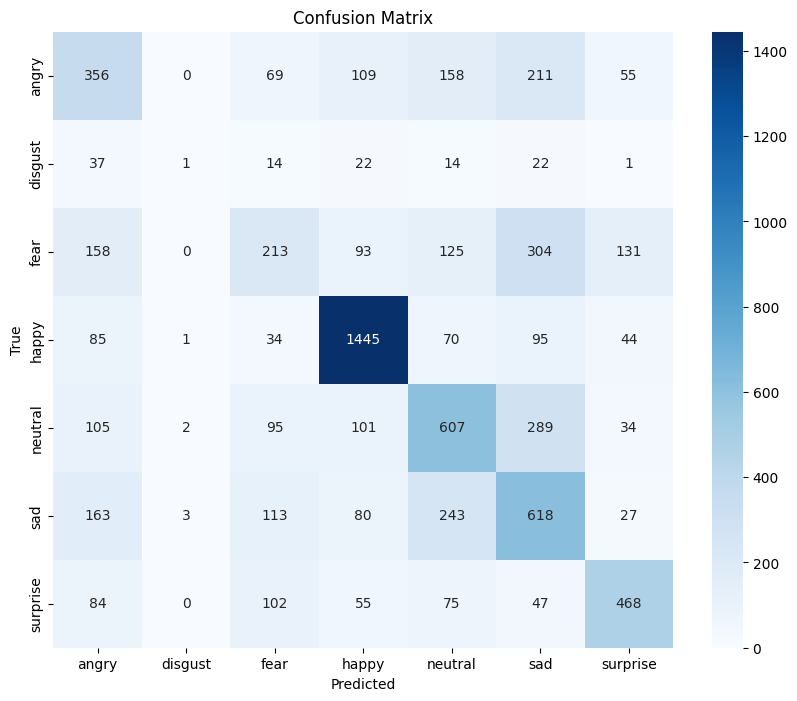

In [100]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train.label_map.keys(), yticklabels=train.label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
print(classification_report(y_true, y_pred, target_names=train.label_map.keys()))